# 环境变量

In [2]:
output_dir='./output_zero/'
faiss_path=output_dir+'faiss_index'
distilled_log_dir=output_dir+'distilled_log/'
char_freq_path=output_dir+'char_freq.json'
rename_map_path=output_dir+'rename_map.json'
all_chapters_path=output_dir+'all_chapters.json'

# outputs
train_data_path=output_dir+'train.json'
test_data_path=output_dir+'test.json'
merged_log_path=output_dir+'merged_log.json'
text_log_path=output_dir+'merged_log.txt'
unlabeled_expression_path=output_dir+'unlabeled_expression.json'
expression_map_path=output_dir+'expression_map.json'
rp_train_data_cache_path=output_dir+'train_rp.cache.json'
rp_train_data_path=output_dir+'train_rp.json'

token_per_char=0.65 # will be updated later
max_llm_tokens=500
max_prompt_tokens=450
max_response_tokens=50
assert max_prompt_tokens+max_response_tokens==max_llm_tokens
min_response_text_len=1
max_chaper_summary_tokens=80
max_character_summary_tokens=80
max_bg_hint_tokens=150


tokenizer_name='D:\ml\chatglm-6b-int4-qe'


# cache_dir='./.cache'
# train_data_path='./train.json'
# test_data_path='./test.json'
# uncategorized_expression_path='./uncategorized_expression.json'
# expression_map_path='./expression_map.json'
# merged_content_path='./all_content.json'
# merged_interview_path='./all_interview.json'
# merged_history_path='./all_history.txt'
# test_data_size=200
# tokenizer_name='D:\ml\chatglm-6b-int4-qe'
# roleplay_propotion=.7
# interview_propotion=.3
# include_act=False
# include_think=False
# include_interview=False

# max_history_tokens=350
# max_prompt_tokens=380
# # bg_hint_num=2
# bg_hint_num=0



# output_dir='./output_shana/'

# faiss_path=output_dir+'faiss_index'

# 邀请邻居家的小孩子来帮忙，这样可以加快训练速度

In [3]:
from my_llm import llm_chatgpt as llm

llm('请表演背唐诗\n')

c:\Anaconda3\envs\tensorflow\lib\site-packages\langchain\llms\openai.py:165: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(
c:\Anaconda3\envs\tensorflow\lib\site-packages\langchain\llms\openai.py:676: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(


请表演背唐诗
往事知多少，小楼昨夜又东风。
故国不堪回首月明中。
雕栏玉砌应犹在，只是朱颜改。
问君能有几多愁，恰似一江春水向东流。


'往事知多少，小楼昨夜又东风。\n故国不堪回首月明中。\n雕栏玉砌应犹在，只是朱颜改。\n问君能有几多愁，恰似一江春水向东流。'

# 加载库

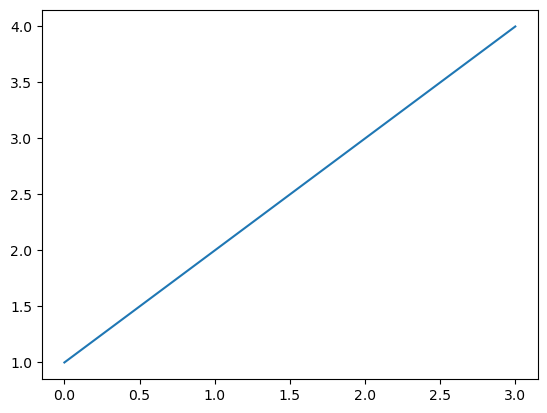

In [4]:
# run this to avoid chinese bug
import matplotlib.pyplot as plt
plt.plot([1,2,3,4])
plt.show()
import matplotlib
# chinese
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
import numpy as np

In [5]:
import random,os,json
from tqdm.auto import tqdm

# 校订人名

In [6]:
rename_map=json.load(open(rename_map_path,encoding='utf-8'))
# expression_map=json.load(open(expression_map_path,encoding='utf-8')) if os.path.exists(expression_map_path) else {}

def revise_text(text):
    for from_name,to_name in rename_map.items():
        text=text.replace(from_name,to_name)
    return text

def revise_json_(obj):
    if isinstance(obj,str):
        return revise_text(obj)
    if isinstance(obj,list):
        return [revise_json_(item) for item in obj]
    if isinstance(obj,dict):
        return {revise_text(k):revise_json_(v) for k,v in obj.items()}
    return obj

# 加载所有章节总结


In [7]:
all_chapters=json.load(open(all_chapters_path,encoding='utf-8'))
all_chapters={int(k):revise_json_(v) for k,v in all_chapters.items()}
print('load {} chapters'.format(len(all_chapters)))

def find_chapter_id(chunk_id):
    for iChapter,chapter in all_chapters.items():
        if chunk_id in chapter['chunk_ids']:
            return iChapter
    return None

def try_get_character_info(char,chapter_id):
    char=rename_map.get(char,char)
    chapter=all_chapters[chapter_id]
    if 'characters' in chapter and char in chapter['characters']:
        return chapter['characters'][char]
    else:
        return None
    
def generate_character_summary(char,chapter_id):
    char=rename_map.get(char,char)
    info=try_get_character_info(char,chapter_id)
    if info is None:
        return ''
    summary=char
    if info.get('role',None):
        summary+=' '+info['role']
    if info.get('goal',None):
        summary+=' '+info['goal']
    if info.get('obstacle',None):
        summary+=' '+info['obstacle']
    if info.get('plan',None):
        summary+=' '+info['plan']
    return summary

generate_character_summary('露易丝',find_chapter_id(555))

load 188 chapters


'露易丝 女主角，故事的重要人物，被才人拯救并得到了治愈 理解自己的感情，得救 被瓦尔德打败，心理困惑 拒绝瓦尔德的求婚，等待才人的救援'

# 加载并校对gpt返回的json跑团记录

In [8]:
import re

In [9]:
import json,random,re
from glob import glob
import os

chunks={}
for path in glob(os.path.join(distilled_log_dir,'RESPONSE*.json')):
    with open(path) as f:
        chunk=json.load(f)
        chunk_id=chunk['id']
        chapter_id=find_chapter_id(chunk['id'])
        assert chunk['chapter_id']==chapter_id
        if 'content' in chunk and chunk['content']:
            for item in chunk['content']:
                item['src_id']=chunk['id']
                item['chapter_id']=chapter_id
        chunks[chunk_id]=chunk
chunks=dict(sorted(chunks.items(), key=lambda item: item[0]))

all_content=[item for chunk in chunks.values() if 'content' in chunk and chunk['content'] for item in chunk['content']]


def separate_string_by_max_len(text,max_len):
    parts=re.split(r'([，。！？])',text)
    new_text=''
    while len(parts)>0:
        part=parts.pop(0)
        if len(new_text)+len(part)>max_len:
            yield new_text
            new_text=''
        new_text+=part
    if len(new_text)>0:
        yield new_text
        
def purge_content(all_content):
    for item in all_content:
        item={k:v for k,v in item.items() if v is not None}
        item=revise_json_(item)

        if 'info' in item:
            info_str=item['info']
            if 'expression' in item:
                info_str=item['expression']+' '+info_str
            if 'char' in item:
                info_str=item['char']+' '+info_str
            if 'src_id' not in item:
                print(item)
            yield {'info':info_str,'src_id':item['src_id'],'chapter_id':item['chapter_id']}
        if 'char' in item:
            base_info={'char':item['char'],'src_id':item['src_id'],'chapter_id':item['chapter_id']}
            if 'expression' in item and item['expression']:
                base_info['expression']=item['expression']
            if 'think' in item and item['think'] and 'say' in item and item['say'] and len(item['think'])+len(item['say'])<.5*max_response_tokens/token_per_char:
                base_info['think']=item['think']
                base_info['say']=item['say']
                yield base_info
            else:
                if 'think' in item and item['think']:
                    for think_part in separate_string_by_max_len(item['think'],max_len=max_response_tokens/token_per_char):
                        yield {**base_info,'think':think_part}
                if 'say' in item and item['say']:
                    for say_part in separate_string_by_max_len(item['say'],max_len=max_response_tokens/token_per_char):
                        yield {**base_info,'say':say_part}
            if 'act' in item and item['act']:
                for act_part in separate_string_by_max_len(item['act'],max_len=max_response_tokens/token_per_char):
                    yield {**base_info,'act':act_part}
                    

all_content=list(purge_content(all_content))
for iItem,item in enumerate(all_content):
    item['item_id']=iItem

all_content[:10]

print('Total content chunks:', len(chunks))
print('Total items:', len(all_content))

json.dump(all_content, open(merged_log_path, 'w', encoding='utf-8'), ensure_ascii=False, indent=2)
for item in random.sample(all_content,5):
    print(item)

Total content chunks: 2318
Total items: 34984
{'char': '谢斯塔', 'src_id': 1512, 'chapter_id': 113, 'say': '现在，在特里斯汀流行的书哟。', 'item_id': 22928}
{'char': '塔芭莎', 'src_id': 76, 'chapter_id': 2, 'say': '是谋反骚动。', 'item_id': 1234}
{'char': '安莉埃塔', 'src_id': 2218, 'chapter_id': 175, 'say': '欢迎你们的到来。来，到这边。虽然作为欢迎祖国的英雄来说，我这里有些简陋……', 'item_id': 33419}
{'char': '客人', 'src_id': 865, 'chapter_id': 63, 'say': '你怎么了啊？', 'item_id': 13180}
{'char': '露易丝', 'src_id': 1612, 'chapter_id': 122, 'expression': '发怒', 'say': '你要是再过分盯着看的话，我就要处罚你喽。哈啊~~，我说你啊，为什么是非要诞生在这个世界上的生命体呢？', 'item_id': 24420}


# 提取表情，使用gpt聚类

In [10]:
# all_expressions=set(item['expression'] for item in all_content if 'expression' in item)
# print('all_expressions:', all_expressions)

unlabeled_expression_freq={}
for item in all_content:
    if 'expression' in item:
        unlabeled_expression_freq[item['expression']]=unlabeled_expression_freq.get(item['expression'], 0)+1
unlabeled_expression_freq={k: v for k, v in sorted(unlabeled_expression_freq.items(), key=lambda item: item[1], reverse=True)}

print('unlabeled_expression_freq:', unlabeled_expression_freq)

with open(unlabeled_expression_path, 'w', encoding='utf-8') as f:
    json.dump(unlabeled_expression_freq, f, ensure_ascii=False, indent=2)
print('saved unlabeled expressions to', unlabeled_expression_path)

unlabeled_expression_freq: {'惊讶': 576, '愤怒': 298, '微笑': 147, '惊恐': 138, '生气': 129, '不满': 99, '得意': 99, '疑惑': 85, '冷漠': 78, '害羞': 76, '兴奋': 72, '痛苦': 71, '悲伤': 70, '颤抖': 70, '紧张': 67, '羞涩': 64, '困惑': 63, '严肃': 61, '哭泣': 60, '认真': 58, '坚定': 56, '点头': 55, '尴尬': 52, '开心': 48, '高兴': 47, '好奇': 43, '犹豫': 42, '自信': 42, '担忧': 39, '感动': 39, '摇头': 37, '害怕': 37, '无奈': 37, '思考': 34, '激动': 33, '担心': 33, '不安': 32, '瞪眼': 31, '温柔': 31, '沉默': 31, '慌张': 31, '解释': 30, '震惊': 27, '怀疑': 26, '冷静': 25, '羞愧': 24, '吃惊': 23, '笑': 23, '感激': 23, '抱怨': 22, '平静': 22, '叹气': 21, '专注': 20, '脸红': 20, '焦急': 19, '期待': 19, '低头': 18, '嘲讽': 18, '嘲笑': 18, '神秘': 18, '疼痛': 17, '失望': 16, '大笑': 16, '慌乱': 15, '笑着': 15, '恐惧': 15, '不耐烦': 15, '大叫': 14, '呆滞': 14, '严厉': 14, '惊慌': 14, '沮丧': 13, '自豪': 13, '轻蔑': 13, '调侃': 13, '无力': 13, '红着脸': 13, '为难': 12, '天真': 12, '不屑': 12, '冷酷': 12, '难过': 12, '赞叹': 12, '皱眉': 12, '感叹': 11, '安慰': 11, '询问': 11, '通红': 11, '惊愕': 11, '嫉妒': 10, '热情': 10, '寂寞': 10, '茫然': 10, '笑容': 10, '闭上眼睛': 10, '烦恼': 10, '难为情

In [11]:
from langchain.chains.base import Chain
import json
import re
from my_llm import llm_chatgpt as llm


class LabelExpressionChain(Chain):
    llm:object=None
    labels:list='平静，专注，微笑，兴奋，微怒，大怒，惊讶，恐惧，微哀，大哭，害羞，困惑，白眼'.split('，')
    @property
    def input_keys(self):
        return ['unknown_expression']
    @property
    def output_keys(self):
        return ['label']
    prmopt='''请将“{unknown_expression}”归类为下列类别中的一种：
{labels}
“{unknown_expression}”的类别是：'''
    def _call(self,inputs:dict)->dict:
        inputs['labels']=self.labels
        inputs['unknown_expression']=re.sub(r'[^\u4e00-\u9fa5]', '', inputs['unknown_expression'])
        if inputs['unknown_expression'] in self.labels:
            return {'label':inputs['unknown_expression']}
        query=self.prmopt.format(**inputs)
        response=self.llm(query)
        response=re.sub(r'[^\u4e00-\u9fa5]', '', response)
        if response not in self.labels:
            response=None
        return {'label':response}

label_expression_chain=LabelExpressionChain(llm=llm)

llm.show_query=llm.show_response=True
label_expression_chain('不耐烦')
llm.show_query=llm.show_response=False


请将“不耐烦”归类为下列类别中的一种：
['平静', '专注', '微笑', '兴奋', '微怒', '大怒', '惊讶', '恐惧', '微哀', '大哭', '害羞', '困惑', '白眼']
“不耐烦”的类别是：微怒


In [12]:
import os
from tqdm.auto import tqdm
if os.path.exists(expression_map_path):
    with open(expression_map_path, 'r', encoding='utf-8') as f:
        expression_map=json.load(f)
        print('loaded expression_map from', expression_map_path)
else:
    expression_map={}

for unknown_expression in tqdm(unlabeled_expression_freq):
    if expression_map.get(unknown_expression,None) is None:
        response=label_expression_chain(unknown_expression)
        if response['label'] is None:
            print('failed', unknown_expression)
        print(unknown_expression, '->', response['label'])
        expression_map[unknown_expression]=response['label']
        json.dump(expression_map, open(expression_map_path, 'w'),ensure_ascii=False,indent=4)



loaded expression_map from ./output_zero/expression_map.json


  0%|          | 0/1482 [00:00<?, ?it/s]

emoji_freq: {'惊讶': 769, '困惑': 741, '微哀': 691, '平静': 663, '恐惧': 627, '大怒': 584, '微怒': 580, '微笑': 529, '兴奋': 455, '害羞': 381, '专注': 340, '大哭': 103, '白眼': 37}


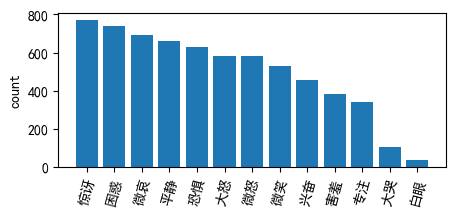

In [13]:
for item in all_content:
    if 'expression' in item and item['expression'] in expression_map and expression_map[item['expression']] is not None:
        item['emoji']=expression_map[item['expression']]

emoji_freq={}
for item in all_content:
    if 'emoji' in item:
        emoji_freq[item['emoji']]=emoji_freq.get(item['emoji'], 0)+1
emoji_freq={k: v for k, v in sorted(emoji_freq.items(), key=lambda item: item[1], reverse=True)}

print('emoji_freq:', emoji_freq)


plt.figure(figsize=(5, 2))
plt.bar(list(emoji_freq.keys()), list(emoji_freq.values()))
plt.xticks(rotation=75)
plt.ylabel('count')
# plt.yscale('log')
# plt.ylim(1,np.max(list(emoji_freq.values()))*2)
plt.show()

# 加载FAISS知识索引

In [14]:
# import importlib,my_faiss;importlib.reload(my_faiss)
from my_faiss import FAISS,embeddings,get_bg_hint
get_bg_hint.vector_store=FAISS.load_local(faiss_path, embeddings)
dialogue='才人：起床了！\n路易斯：'
bg_hint=get_bg_hint(dialogue,max_text_len=500,show_score=True)
print(bg_hint)
# # llm(bg_hint+'\n请扮演路易斯\n'+dialogue)

No sentence-transformers model found with name D:\ml\text2vec-large-chinese. Creating a new one with MEAN pooling.
No sentence-transformers model found with name D:\ml\text2vec-large-chinese. Creating a new one with MEAN pooling.


【露易丝 的性格易怒，容易骂人，有点糊涂（跟才人比），为了小事常常生气。（0.17）】
【拉·瓦利埃尔公爵 在托里斯特因有很大的影响力，涉足军、政、商三界，与王室关系密切，动画版第十二话认可了露易丝与才人的关系，同意让露易丝嫁给才人，在罗马尼亚大圣堂做了见证。（0.17）】
【平贺才人 已与露易丝同居中。同时被书中许多女性角色爱慕著。喜欢露易丝。（0.14）】
【平贺才人 他的称号：修瓦里埃骑士（见习骑士），子爵(结尾被封) 他喜欢的人：露易丝（表白过很多次） 他的妻子:露易丝（在大结局和露易丝结婚）（0.12）】
【平贺才人 亚成婚，后与露易丝回到自己所属的世界，回到自己家中。（0.12）】
【露易丝 起初对身为贵族的身份有着很强的自觉心，拥有常人N倍的自尊心，后来受才人影响，逐渐放下这份执着，转而为才人着想。在后期已经可以对才人敞开心扉，坦诚相待。（0.12）】
【安丽埃塔 小说16-17卷有欲从露易丝那里里夺取才人，羡慕著露易丝。（0.12）】
【露易丝 动画第三期中为救出塔芭莎而放弃贵族身份，但被公主赏识，成为王位继承人。喜欢平贺才人。（0.11）】


# 生成跑团式的回复文本

In [15]:

def generate_line(item,no_char=False,no_emoji=False):
    if 'info' in item:
        return '【'+item['info']+'】'
    if 'char' in item:
        char=rename_map.get(item['char'], item['char'])
        if 'act' in item:
            return char+'：'+'\\me '+item['act']
        emoji_text=('\\emoji '+item['emoji']) if 'emoji' in item and not no_emoji else ''
        say_text=item['say'] if 'say' in item else ''
        think_text=('（'+item['think']+'）' if '（' not in item['think'] else item['think']) if 'think' in item else ''
        if no_char:
            return say_text+think_text+emoji_text
        else:
            return char+'：'+say_text+think_text+emoji_text
    return ''
    
def generate_chapter_title_summary(chapter_id):
    title=all_chapters[chapter_id]['title']
    summary=all_chapters[chapter_id].get('summary','') or ''
    for char,info in all_chapters[chapter_id].get('characters',{}).items():
        summary+='\n'+generate_character_summary(char,chapter_id)
    return '='*10+title+'='*10+'\n'+summary+'\n'

all_log_text=''
prev_chapter_id=None
for item in tqdm(all_content):
    if prev_chapter_id!=item['chapter_id']:
        all_log_text+=generate_chapter_title_summary(item['chapter_id'])
        prev_chapter_id=item['chapter_id']
    line=generate_line(item)
    if line is not None:
        all_log_text+=line+'\n'

open(text_log_path, 'w', encoding='utf-8').write(all_log_text)
print('saved to', text_log_path)

  0%|          | 0/34984 [00:00<?, ?it/s]

saved to ./output_zero/merged_log.txt


# 计算一个字需要多少token

In [16]:

from transformers import AutoTokenizer
tokenizer=AutoTokenizer.from_pretrained(tokenizer_name,trust_remote_code=True)

def get_tokenized_length(text):
    tokenizer_text=tokenizer(text, return_tensors='pt')
    return len(tokenizer_text['input_ids'][0])


def clamp_by_tokenizer(text,max_length,return_length=False):
    tokenizer_text=tokenizer(text, return_tensors='pt')
    tokenized_length=min(len(tokenizer_text['input_ids'][0]), max_length)
    if len(tokenizer_text['input_ids'][0])>=max_length:
        text=tokenizer.decode(tokenizer_text['input_ids'][0][-max(1,max_length-1):])
    if return_length:
        return text, tokenized_length
    else:
        return text

text_samples=[chunk['text'] for chunk in list(chunks.values())[:10]]
chunk_lengths=[len(text) for text in text_samples]
chunk_tokenized_lengths=[get_tokenized_length(text) for text in text_samples]
print('chunk_lengths:', chunk_lengths)
print('chunk_tokenized_lengths:', chunk_tokenized_lengths)
print('ratios:', [a/b for a,b in zip(chunk_tokenized_lengths, chunk_lengths)])
import numpy as np
token_per_char=np.mean([a/b for a,b in zip(chunk_tokenized_lengths, chunk_lengths)])
print('token_per_char:', token_per_char)

def estimate_tokenized_length(text):
    return max(1,int(len(text)*token_per_char)) if len(text)>0 else 0

Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.


chunk_lengths: [715, 738, 706, 713, 637, 748, 735, 721, 742, 743]
chunk_tokenized_lengths: [461, 459, 463, 431, 428, 464, 488, 447, 464, 476]
ratios: [0.6447552447552447, 0.6219512195121951, 0.6558073654390935, 0.6044880785413744, 0.6718995290423861, 0.6203208556149733, 0.6639455782312925, 0.6199722607489597, 0.6253369272237197, 0.6406460296096904]
token_per_char: 0.6369123088718929


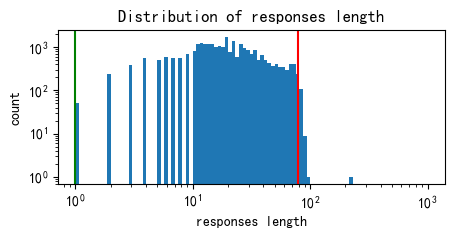

Number of character responses:  27830
Number of overlength responses:  140
Number of underlength responses:  2


In [17]:
all_char_responses=[generate_line(item,no_char=True) for item in all_content if 'char' in item]
plt.figure(figsize=(5, 2))
plt.hist([len(response) for response in all_char_responses], bins=np.logspace(0, 3, 100), log=True)

plt.axvline(x=max_response_tokens/token_per_char, color='r')
plt.axvline(x=min_response_text_len, color='g')
plt.xscale('log');plt.xlabel('responses length');plt.ylabel('count');plt.title('Distribution of responses length');plt.show()
print('Number of character responses: ', len(all_char_responses))

print('Number of overlength responses: ', len([response for response in all_char_responses if estimate_tokenized_length(response)>max_response_tokens]))
print('Number of underlength responses: ', len([response for response in all_char_responses if estimate_tokenized_length(response)<min_response_text_len]))

# 提供上下文

对每个对话扮演条目，需要给够上下文，角色设定，背景信息，以及角色在本章中的动机等信息！

In [18]:
item=random.sample([item for item in all_content if 'char' in item],1)[0]
# token_per_char


def generate_prompt(item,max_prompt_tokens,max_chaper_summary_tokens,max_character_summary_tokens,max_bg_hint_tokens,prev_items_num=100):
    assert 'char' in item
    max_prompt_text_len=int(max_prompt_tokens/token_per_char)
    max_chaper_summary_text_len=int(max_chaper_summary_tokens/token_per_char)
    max_character_summary_text_len=int(max_character_summary_tokens/token_per_char)
    max_bg_hint_text_len=int(max_bg_hint_tokens/token_per_char)

    iItem=item['item_id']
    prev_items=all_content[max(0,iItem-prev_items_num):iItem]
    prev_items=[prev_item for prev_item in prev_items if item['chapter_id']==prev_item['chapter_id']]
    previous_lines=[generate_line(prev_item) for prev_item in prev_items]
    character_summary=generate_character_summary(item['char'],item['chapter_id'])
    chapter_summary=all_chapters[item['chapter_id']].get('summary','')
    bg_hint_query=character_summary+'\n'+chapter_summary+'\n'+'\n'.join(previous_lines)
    bg_hint=get_bg_hint(bg_hint_query,max_text_len=max_bg_hint_text_len,show_score=False)
    prompt1=''
    prompt2=rename_map.get(item['char'], item['char'])+'：'
    if len(chapter_summary)>0:
        prompt1+='{'+chapter_summary[:max_chaper_summary_text_len]+'}\n'
    if len(character_summary)>0:
        prompt1+='【'+character_summary[:max_character_summary_text_len]+'】\n'
    if len(bg_hint)>0:
        prompt1+=bg_hint+'\n'
    for prev_line in previous_lines[::-1]:
        next_prompt2=prev_line+'\n'+prompt2
        if (len(prompt1)+len(next_prompt2))>=max_prompt_text_len*.9 and get_tokenized_length(prompt1+next_prompt2)>=max_prompt_tokens:
            break
        prompt2=next_prompt2
    prompt=prompt1+prompt2
    return clamp_by_tokenizer(prompt,max_prompt_tokens)

prompt=generate_prompt(item,
                       max_prompt_tokens=max_prompt_tokens,
                       max_chaper_summary_tokens=max_chaper_summary_tokens,
                       max_character_summary_tokens=max_character_summary_tokens,
                       max_bg_hint_tokens=max_bg_hint_tokens)
print('prompt:', prompt)
print('tokenized length:', get_tokenized_length(prompt))
ground_truth=generate_line(item, no_char=True)
print('ground_truth:', ground_truth)
print('tokenized length:', get_tokenized_length(ground_truth))
# prediction=llm(prompt);print('prediction:', prediction)

prompt: {蒂法尼亚被贝亚托里斯缠着，才人等人想办法让她摆脱。他们让蒂法尼亚装作喜欢女孩子，但贝亚托里斯感到不安。才人和马利寇尔奴决定帮助蒂法尼亚，让她化身为夜之女王蜂向贝亚托里斯表白，但最终两人成为好朋友。才人等人给蒂法妮亚出馊主意，被贝亚托里斯愤怒地使用魔法}
【蒂法妮娅 并且揭穿“贝儿朵莉丝”在无罗马利亚大教主的审问许可书下向蒂法进行异端审问，蒂法不与其计较并说希望能当朋友，之后以本人真诚的性格获得众人的接受。】
【蒂法妮娅 才人为了阻止蒂法被审问与“贝儿朵莉丝”求情，之后“基修·杜·格拉蒙”制止才人并告诉才人妨碍审问的话会被当作异端的同伙，会使与自己有关系的人招遇麻烦，才人便向“贝儿朵莉丝”下跪请求不要审问蒂法，】
蒂法妮娅：这胜利也太痛苦了\emoji 微哀
露易丝：还好吗？\emoji 恐惧
【蒂法妮娅 慌张 蒂法尼亚赶忙将褪下的衣服拉了上来】
蒂法妮娅：\me 拉上衣服
马利寇尔奴：闪耀在夜空中的女王蜂的飨宴……。才人，真有你的！还有脱皮那段，竟然完美的将**和艺术结合起来，太了不起了！\emoji 惊讶
才人：是、是吗？\emoji 惊讶
蒂法妮娅：（他们觉得相当有趣吧）\emoji 微哀
贝亚托里斯：贝亚托里斯？你这打扮是……\emoji 困惑
贝亚托里斯：\me 跑来
贝亚托里斯：那、那个！\emoji 兴奋
蒂法妮娅：我的求爱？\emoji 惊讶
贝亚托里斯：蒂法尼亚你的求爱！我接受了！\emoji 兴奋
蒂法尼亚：
tokenized length: 446
ground_truth: 啊？呃？啊啊啊啊啊啊啊啊！
tokenized length: 12


# 遍历所有条目，生成训练数据

In [19]:
if os.path.exists(rp_train_data_cache_path):
    train_data=json.load(open(rp_train_data_cache_path, 'r', encoding='utf-8'))
else:
    train_data=[]
for iItem in tqdm(range(len(all_content))):
    item=all_content[iItem]
    if 'char' in item:
        # check if item_id already in train_data
        if any([item['item_id']==iItem for item in train_data]):
            continue
        prompt=generate_prompt(item,
                               max_prompt_tokens=max_prompt_tokens,
                               max_chaper_summary_tokens=max_chaper_summary_tokens,
                               max_character_summary_tokens=max_character_summary_tokens,
                               max_bg_hint_tokens=max_bg_hint_tokens)
        response=generate_line(item, no_char=True)
        if len(response)<min_response_text_len:
            continue
        response=clamp_by_tokenizer(response,max_response_tokens)
        train_data.append({'prompt':prompt, 'response':response, 'item_id':iItem})
    if iItem%300==0 and iItem>0:
        print('processed', iItem, 'items')
        # save train_data to rp_train_data_cache_path
        json.dump(train_data, open(rp_train_data_cache_path, 'w', encoding='utf-8'), ensure_ascii=False, indent=2)
        print('saved to', rp_train_data_cache_path)

print('processed', len(all_content), 'items')
# save train_data to rp_train_data_path
json.dump(train_data, open(rp_train_data_path, 'w', encoding='utf-8'), ensure_ascii=False, indent=2)
print('saved to', rp_train_data_path)

  0%|          | 0/34984 [00:00<?, ?it/s]

processed 300 items
saved to ./output_zero/train_rp.cache.json
processed 600 items
saved to ./output_zero/train_rp.cache.json
processed 900 items
saved to ./output_zero/train_rp.cache.json
processed 1200 items
saved to ./output_zero/train_rp.cache.json
processed 1500 items
saved to ./output_zero/train_rp.cache.json
processed 1800 items
saved to ./output_zero/train_rp.cache.json
processed 2100 items
saved to ./output_zero/train_rp.cache.json
processed 2400 items
saved to ./output_zero/train_rp.cache.json
processed 2700 items
saved to ./output_zero/train_rp.cache.json
processed 3000 items
saved to ./output_zero/train_rp.cache.json
processed 3300 items
saved to ./output_zero/train_rp.cache.json
processed 3600 items
saved to ./output_zero/train_rp.cache.json
processed 3900 items
saved to ./output_zero/train_rp.cache.json
processed 4200 items
saved to ./output_zero/train_rp.cache.json
processed 4500 items
saved to ./output_zero/train_rp.cache.json
processed 4800 items
saved to ./output_zero

# 打乱，合并数据，调整频率，生成train和test.json

In [ ]:
processed_data=random.shuffle(train_data)

output_train_data=processed_data
output_test_data=random.sample(processed_data, 300)
# train_data_path
# test_data_path

json.dump(output_train_data, open(train_data_path, 'w', encoding='utf-8'), ensure_ascii=False, indent=2)
print('saved to', train_data_path)
json.dump(output_test_data, open(test_data_path, 'w', encoding='utf-8'), ensure_ascii=False, indent=2)
print('saved to', test_data_path)


# 未整理的旧代码

In [80]:


def generate_history_text(content:'list[dict]',mode='full',max_history_tokens=max_history_tokens,bg_hint_num=0):
    if bg_hint_num>0:
        tmp_history_text=generate_history_text(content,mode='full',max_history_tokens=max_history_tokens,bg_hint_num=0)
        bg_hint_text=get_bg_hint(tmp_history_text,k=bg_hint_num)+'\n'
    else:
        bg_hint_text=''
    if mode=='full':
        all_text=''
        for item in content[-1::-1]:
            if 'char' in item:
                line=f'{item["char"]}：'+generate_response_text(item)
            elif 'info' in item:
                line=f'【{item["info"]}】'
            else:
                continue
            if estimate_tokenized_length(bg_hint_text+all_text+line+'\n')>max_history_tokens:
                break
            else:
                all_text=line+'\n'+all_text
        return bg_hint_text+all_text
    elif mode=='prev_dialogue':
        for item in content[-1::-1]:
            if 'char' in item and 'say' in item:
                return bg_hint_text+item['say']+'\n'
        return ''
    elif mode=='none':
        return ''
    else:
        raise ValueError(f'Unknown mode: {mode}')

print('mode=none')
print(repr(generate_history_text(all_content[:331], mode='none')))
print('mode=prev_dialogue')
print(generate_history_text(all_content[:331], mode='prev_dialogue',bg_hint_num=3))
print('mode=full')
histoy_text=generate_history_text(all_content[:331], mode='full',bg_hint_num=2)
print(histoy_text)

all_history=generate_history_text(all_content, mode='full', max_history_tokens=1e99)
with open(merged_history_path, 'w', encoding='utf-8') as f:
    f.write(all_history)
print('history text length (character):', len(all_history))
print('saved history text to', merged_history_path)

mode=none
''
mode=prev_dialogue


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:34                                                                                   │
│ in generate_history_text:3                                                                       │
│ in generate_history_text:11                                                                      │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'generate_response_text' is not defined

### 生成训练条目

我想让ChatGLM模型学习小说里的角色设定，并尝试扮演该角色。我准备的训练数据有。1.利用ChatGPT将小说文本转换成TRPG跑团记录格式。2.让ChatGPT阅读文本并生成对小说角色的模拟采访。

可以选择在prompt中加入较长的历史上下文，或者只提供问句，甚至不提供。简单的训练（抱歉没有等到收敛）表明，如果不提供上下文让模型生成角色的下一步言行会让模型倾向于使用“嗯”，“好的”。一类的回答。这是因为在原则上没有足够找到正确答案的上下文信息时摆烂是最稳妥的。

但是我希望模型能够尝试不依靠上下文提示自己记忆背景信息，可能即使有上下文时模型仍然需要记忆一些东西才可以生成正确的回复。

我希望额外加入的问答训练能够帮助模型保持ChatGLM的智力。在使用ChatGPT蒸馏数据以微调ChatGLM时，这些问答数据确实是ChatGPT仅仅根据窗口中的上下文推断出来的。那么是否应该把窗口中的上下文包括在prompt中呢？ChatGPT建议保持上下文信息数量适当可防止模型过度依赖上下文。

In [11]:
all_interview[13]

{'respondent': '玩偶',
 'ask': '你们觉得我和铁珠的关系怎么样？',
 'answer': '我们是密不可分的伙伴，一起立功。',
 'src_id': 2}

In [12]:
assert False, 'TODO optimize faiss search'

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AssertionError: TODO optimize faiss search

In [27]:
from tqdm.auto import tqdm
def get_rp_task(all_content,history_mode='full',bg_hint_num=2,max_history_tokens=max_history_tokens,use_dm_prompt=True):
    train_data=[]
    for iItem, item in tqdm(list(enumerate(all_content))):
        if 'char' in item:
            char=rename_map.get(item['char'], item['char'])
            if char in selected_char:
                if 'say' in item or ('think' in item and include_think) or ('act' in item and include_act):
                    response_text=generate_response_text(item)
                    history_text=generate_history_text(all_content[:iItem],mode=history_mode,max_history_tokens=max_history_tokens,bg_hint_num=bg_hint_num)
                    dm_prompt=generate_dm_prompt(item) if use_dm_prompt else ''
                    prompt_text=history_text+dm_prompt+char+'：'
                    # prompt_text_tokenized_length=get_tokenized_length(prompt_text)
                    # assert prompt_text_tokenized_length<=max_prompt_tokens, f'prompt_text_tokenized_length={prompt_text_tokenized_length} > max_prompt_length={max_prompt_tokens}'
                    prompt_text,prompt_tokenized_length=clamp_by_tokenizer(prompt_text, max_prompt_tokens, return_length=True)
                    response_tokenized_length=get_tokenized_length(response_text)
                    train_data.append({'char':char, 'response': response_text,'prompt': prompt_text,'task':'rp','src_id':iItem,'prompt_tokenized_length':prompt_tokenized_length,'response_tokenized_length':response_tokenized_length})
    print('Total generated data:', len(train_data))
    return train_data


# {'respondent': '玩偶',
#  'ask': '你们觉得我和铁珠的关系怎么样？',
#  'answer': '我们是密不可分的伙伴，一起立功。',
#  'id': 2}

def find_content_with_id(id):
    for content in contents:
        if 'id' in content and content['id']==id:
            return content
    return None

def get_inteview_task(all_interview,history_mode='full',bg_hint_num=2,max_history_tokens=max_history_tokens):
    train_data=[]
    for iItem, item in tqdm(list(enumerate(all_interview))):
        content=find_content_with_id(item['src_id'])['content']
        assert content is not None, f'Cannot find content with id={item["id"]}'
        char=rename_map.get(item['respondent'], item['respondent'])
        if char in selected_char:
            response_text=item['answer']
            history_text=generate_history_text(content,mode=history_mode,max_history_tokens=max_history_tokens,bg_hint_num=bg_hint_num)
            interviewer_prompt=f'{get_random_inteviewer_name()}：{item["ask"]}\n'
            prompt_text=history_text+interviewer_prompt+char+'：'
            # prompt_text_tokenized_length=get_tokenized_length(prompt_text)
            # assert prompt_text_tokenized_length<=max_prompt_tokens, f'prompt_text_tokenized_length={prompt_text_tokenized_length} > max_prompt_length={max_prompt_tokens}'
            prompt_text,prompt_tokenized_length=clamp_by_tokenizer(prompt_text, max_prompt_tokens, return_length=True)
            response_tokenized_length=get_tokenized_length(response_text)
            train_data.append({'char':char, 'response': response_text,'prompt': prompt_text,'task':'interview','src_id':iItem,'prompt_tokenized_length':prompt_tokenized_length,'response_tokenized_length':response_tokenized_length})
    print('Total generated data:', len(train_data))
    return train_data


random.seed(42)
train_data=[]
train_data+=get_rp_task(all_content, history_mode='full',bg_hint_num=bg_hint_num, use_dm_prompt=False)
if include_interview:
    train_data+=get_inteview_task(all_interview, history_mode='full',bg_hint_num=bg_hint_num)


  0%|          | 0/22765 [00:00<?, ?it/s]

Total generated data: 12684


  0%|          | 0/8319 [00:00<?, ?it/s]

Total generated data: 7576


<Figure size 500x200 with 0 Axes>

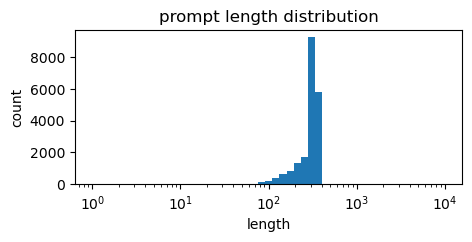

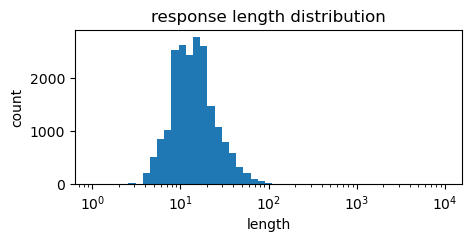

In [28]:
import matplotlib.pyplot as plt

# see prompt length distribution
plt.figure(figsize=(5, 2))
plt.hist([item['prompt_tokenized_length'] for item in train_data], bins=np.logspace(0, 4, 50))
plt.xscale('log');plt.xlabel('length');plt.ylabel('count');plt.title('prompt length distribution');plt.show()

# see response length distribution
plt.figure(figsize=(5, 2))
plt.hist([item['response_tokenized_length'] for item in train_data], bins=np.logspace(0, 4, 50))
plt.xscale('log');plt.xlabel('length');plt.ylabel('count');plt.title('response length distribution');plt.show()

### 调整数据频率

In [43]:

def adjust_data_frequency(train_data):
    for item in train_data:
        frequency=1
        if len(item['response'])<5:
            frequency=0.1
        elif len(item['response'])<10:
            frequency=0.2
        elif len(item['response'])<20:
            frequency=1
        elif len(item['response'])<50:
            frequency=2
        else:
            frequency=5
        if item['task']=='interview':
            frequency*=len(all_content)/len(all_interview)/roleplay_propotion*interview_propotion
        frequency*=1
        for _i in range(int(frequency)):
            yield item    

train_data_argumented=list(adjust_data_frequency(train_data))



for item in random.sample(train_data_argumented, 10):
    print(item['prompt'][-50:], end='》》')
    print(item['response'])
    print()


    
import random
random.seed(42)
random.shuffle(train_data_argumented)

成这样？自己是不是也会变成这样？)
【深蓝色火粉沾在他们身上】
记者：你们为什么要寻找我？
玛琼琳：》》我不知道，他们只是内心有一股冲动驱使他们去寻找我。

内，形貌便能‘自在’显现。
悠二：呼~恩，确实只要一提到与火有关的魔神，通常都回带着刀或剑。
悠二：》》(他对于‘魔神’的印象顶多是来自在国营电视台看过的不动明王，或者是过去不知名的特效电影中所出现的陶俑那一类的程度而已。)

… \emoji 害羞
悠二：吉田同学？ \emoji 惊讶
【夏娜是个火雾战士，比较冷淡】
吉田：》》那……那个，小缘，刚刚，体育课的时候，真……谢谢你。 \emoji 害羞

涉别人的行动了？】
【既然左右双翼已经断了，那家伙也到此为止了】
评论员：你在回忆什么？
火雾战士：》》我在回忆一场兵荒马乱的战斗，一身黑衣飘扬的女子慢条斯理地说道：到这里就够了，接下来由我跟亚拉斯特尔来处理。

想，应该是我所编写的调音自在法，受到某种干扰的结果
【玛琼琳和某人在讨论扭曲现象的来源】
贝海默特：》》呼嗯，看来是这样没错，事实上，我们也大致猜到是哪个‘使徒’会做出这种事。

……那个，请问……
魔神：怎么了，还不快跑！
悠二：\me 横越马路
悠二：\me 跑上堤防
悠二：》》(一想到曾经在这里欣赏到的美景，这分差事便不觉得辛苦)

。】
梅利希姆：对，就像这样。
少女：！
少女：\me 感觉到梅利希姆体内凝聚了‘两股’力量
夏娜：》》(攻击力逐渐增强当中——)

…然后破坏现在这层才开始建立关系的话……)
【主角意识到自己的懦弱和半吊子的觉悟，感到自责】
主角：》》(自己对于坂井悠二繁荣感情，难道脆弱到仅仅因为内心一个忧虑，就准备打退堂鼓了吗？)

中燃烧着一团炽盛火焰，底部没有燃料，只有一个银制的空水盘】
问询人：你为什么要成为火雾战士？
夏娜：》》我一开始就是为了成为火雾战士而活，而且自己并没有感到任何不满，这一切她都明白。同时也在学习之中得知，成为火雾战士就不再是人类，永无至尽的战斗之路，以及战斗这件事情本身。尽管内心对于这一切怀抱着不安、恐惧、踌躇，却还是充满了坚强、冀望、渴求与决心。

了！
夏娜：\me 灌输翅膀的力量，加速前进
【巨狼踩碎大楼崩坍的屋顶，瓦砾掉落在两人头上】
巨狼：》》咆噢噢噢噢噢噢噢噢噢！！



### 保存训练数据到json

In [44]:
#pick test data randomly
output_test_data=random.sample(train_data_argumented, test_data_size)

# remove test data from train data
output_train_data=[item for item in train_data_argumented if item not in output_test_data]

json.dump(output_train_data, open(train_data_path, 'w', encoding='utf-8'), ensure_ascii=False, indent=2)
print('Saved to', train_data_path)
print('Total train data:', len(output_train_data))
import random
random.seed(42)

json.dump(output_test_data, open(test_data_path, 'w', encoding='utf-8'), ensure_ascii=False, indent=2)
print('Saved to', test_data_path)
print('Total test data:', len(output_test_data))

Saved to ./train.json
Total train data: 31640
Saved to ./test.json
Total test data: 200


# trash code

In [ ]:
assert False, 'stop here'

In [ ]:
# import json,random
# from glob import glob


# def purge_content1(content):
#     for item in content:
#         if 'char' in item:
#             char_and_exp={'char':item['char']}
#             if 'expression' in item:
#                 char_and_exp['expression']=item['expression']
#             if 'say' in item and item['say'] is not None and len(item['say'])>0:
#                 yield {**char_and_exp, 'say': item['say']}
#             if 'think' in item and item['think'] is not None and len(item['think'])>0:
#                 yield {'char': item['char'], 'think': item['think']}
#             if 'act' in item and item['act'] is not None and len(item['act'])>0:
#                 yield {**char_and_exp,  'act': item['act']}
#             # if not any(k in item for k in ['say', 'think', 'act']):
#             #     yield char_and_exp
#         if 'info' in item:
#             yield {'info': item['info']}

# # combine continuous say
# def purge_content2(content):
#     prev_item={}
#     for item in content:
#         if 'say' in item:
#             if 'say' in prev_item and item.get('char', 'ERROR1')==prev_item.get('char', 'ERROR2'):
#                 prev_item['say']+=item['say']
#                 continue
#         if len(prev_item)>0:
#             yield prev_item
#         prev_item=item
#     if len(prev_item)>0:
#         yield prev_item

# def purge_content(content):
#     return purge_content2(purge_content1(content))

# contents=[]
# for path in glob(f'{cache_dir}/LOG_RESPONSE_*.json'):
#     with open(path, 'r', encoding='utf-8') as f:
#         try:
#             content=json.load(f)
#             content['content']=list(purge_content(content['content']))
#             content['id']=int(path.split('_')[-1].split('.')[0])
#             for item in content['content']:
#                 item['src_id']=content['id']
#             contents.append(content)
#         except Exception as e:
#             print('Error:', path, e)
#             raise e
# contents=sorted(contents, key=lambda x: x['id'])


# all_content=[]
# for content in contents:
#     for item in content['content']:
#         all_content.append(item)

# for item in random.sample(all_content, 10):    
#     print(item)
    
# print('Total content chunks:', len(contents))
# print('Total items:', len(all_content))

# json.dump(all_content, open(merged_content_path, 'w', encoding='utf-8'), ensure_ascii=False, indent=2)

{'char': '悠二', 'act': '被甩来甩去，受到音波挤压翻搅', 'src_id': 264}
{'info': '各俱乐部和班级也将各种模拟店的摊子摆了起来，展示的摊位一直向学校外面的大路上延伸开去。', 'src_id': 1634}
{'char': '男子', 'say': '想打倒我千变修德南，还嫌太嫩！', 'src_id': 394}
{'info': '成为一个真正的敌人', 'src_id': 614}
{'info': '蒂丽亚把这个反应视为完全放弃挣扎，于是志得意满的宣布处刑方式：', 'src_id': 456}
{'char': '悠二', 'think': '对于之前好不容易克服了痛苦至极的烦恼才向吉田表明的秘密，现在居然随随便便公开宣扬的状况感到全身无力。', 'src_id': 848}
{'char': 'unknown', 'think': '只要是他塑造出来的妄想一律满足，许他恣意玩乐。', 'src_id': 1596}
{'char': '佐腾启作', 'expression': '惊讶', 'say': '坂井你那副打扮是怎么回事.?', 'src_id': 909}
{'info': '千草一副惊异的样子，把手掌贴在自己的脸上', 'src_id': 1041}
{'char': 'unknown', 'say': '哈哈哈哈', 'src_id': 1098}
Total content chunks: 1650
Total items: 22765


In [45]:
try:
    del tokenizer,embeddings,vector_store
except:
    pass
import torch
torch.cuda.empty_cache()

In [ ]:
!.\train_roleplaying.bat

### 提取表情，使用gpt聚类

In [ ]:
# all_expressions=set(item['expression'] for item in all_content if 'expression' in item)
# print('all_expressions:', all_expressions)

unlabeled_expression_freq={}
for item in all_content:
    if 'expression' in item:
        unlabeled_expression_freq[item['expression']]=unlabeled_expression_freq.get(item['expression'], 0)+1
unlabeled_expression_freq={k: v for k, v in sorted(unlabeled_expression_freq.items(), key=lambda item: item[1], reverse=True)}

print('unlabeled_expression_freq:', unlabeled_expression_freq)

with open(unlabeled_expression_path, 'w', encoding='utf-8') as f:
    json.dump(unlabeled_expression_freq, f, ensure_ascii=False, indent=2)
print('saved unlabeled expressions to', unlabeled_expression_path)

unlabeled_expression_freq: {'惊讶': 138, '愤怒': 73, '生气': 42, '微笑': 32, '冷漠': 30, '得意': 27, '惊恐': 26, '紧张': 23, '疑惑': 21, '好奇': 19, '困惑': 19, '兴奋': 18, '坚定': 18, '不满': 17, '点头': 17, '害羞': 16, '高兴': 15, '认真': 15, '尴尬': 14, '悲伤': 13, '摇头': 13, '哭泣': 13, '慌张': 13, '开心': 12, '痛苦': 12, '激动': 11, '笑着': 11, '无奈': 11, '解释': 10, '颤抖': 10, '焦急': 9, '瞪眼': 9, '抱怨': 9, '冷静': 9, '自信': 9, '嘲讽': 9, '担心': 9, '羞涩': 9, '专注': 8, '怀疑': 8, '严肃': 8, '沉默': 8, '吃惊': 8, '咬牙切齿': 8, '感动': 8, '神秘': 8, '犹豫': 7, '叹气': 7, '脸红': 7, '思考': 7, '不安': 6, '面无表情': 6, '温柔': 6, '害怕': 6, '茫然': 6, '疼痛': 6, '不甘心': 6, '担忧': 6, '冷酷': 6, '顺从': 5, '寂寞': 5, '残忍': 5, '羞愧': 5, '呆滞': 5, '撅嘴': 5, '红着脸': 5, '可爱': 4, '抱歉': 4, '低头': 4, '震惊': 4, '期待': 4, '慌乱': 4, '淡然': 4, '没趣': 4, '无聊': 4, '失望': 4, '调侃': 4, '感慨': 4, '回忆': 4, '怀念': 4, '肯定': 4, '急切': 4, '嫉妒': 3, '大叫': 3, '淡定': 3, '感叹': 3, '天真': 3, '无表情': 3, '责备': 3, '凶狠': 3, '不屑': 3, '苍白': 3, '注视': 3, '嘲笑': 3, '自豪': 3, '不悦': 3, '轻蔑': 3, '不耐烦': 3, '难为情': 3, '通红': 3, '悲鸣': 3, '冷笑': 3, '沉思': 3, '怒气冲冲

In [ ]:
from langchain.chains.base import Chain
import json
import re
from my_llm import llm_chatgpt as llm


class LabelExpressionChain(Chain):
    llm:object=None
    labels:list='平静，专注，微笑，兴奋，微怒，大怒，惊讶，恐惧，微哀，大哭，害羞，困惑，白眼'.split('，')
    @property
    def input_keys(self):
        return ['unknown_expression']
    @property
    def output_keys(self):
        return ['label']
    prmopt='''请将“{unknown_expression}”归类为下列类别中的一种：
{labels}
“{unknown_expression}”的类别是：'''
    def _call(self,inputs:dict)->dict:
        inputs['labels']=self.labels
        inputs['unknown_expression']=re.sub(r'[^\u4e00-\u9fa5]', '', inputs['unknown_expression'])
        if inputs['unknown_expression'] in self.labels:
            return {'label':inputs['unknown_expression']}
        query=self.prmopt.format(**inputs)
        response=self.llm(query)
        response=re.sub(r'[^\u4e00-\u9fa5]', '', response)
        if response not in self.labels:
            response=None
        return {'label':response}

label_expression_chain=LabelExpressionChain(llm=llm)

llm.show_query=llm.show_response=True
label_expression_chain('不耐烦')
llm.show_query=llm.show_response=False


c:\Anaconda3\envs\tensorflow\lib\site-packages\langchain\llms\openai.py:165: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(
c:\Anaconda3\envs\tensorflow\lib\site-packages\langchain\llms\openai.py:676: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(


请将“不耐烦”归类为下列类别中的一种：
['平静', '专注', '微笑', '兴奋', '微怒', '大怒', '惊讶', '恐惧', '微哀', '大哭', '害羞', '困惑', '白眼']
“不耐烦”的类别是：微怒


loaded expression_map from ./output_zero/expression_map.json


  0%|          | 0/575 [00:00<?, ?it/s]

failed 正经
正经 -> None
装作害怕 -> 微笑
failed 怒气
怒气 -> None
emoji_freq: {'困惑': 206, '平静': 190, '惊讶': 176, '大怒': 163, '微哀': 161, '微怒': 149, '恐惧': 139, '兴奋': 122, '微笑': 117, '害羞': 96, '专注': 90, '大哭': 22, '白眼': 8}


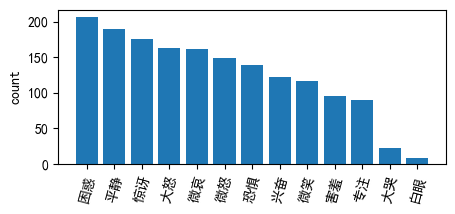

In [ ]:
import os
from tqdm.auto import tqdm
if os.path.exists(expression_map_path):
    with open(expression_map_path, 'r', encoding='utf-8') as f:
        expression_map=json.load(f)
        print('loaded expression_map from', expression_map_path)
else:
    expression_map={}

for unknown_expression in tqdm(unlabeled_expression_freq):
    if expression_map.get(unknown_expression,None) is None:
        response=label_expression_chain(unknown_expression)
        if response['label'] is None:
            print('failed', unknown_expression)
        print(unknown_expression, '->', response['label'])
        expression_map[unknown_expression]=response['label']
        json.dump(expression_map, open(expression_map_path, 'w'),ensure_ascii=False,indent=4)

for item in all_content:
    if 'expression' in item and item['expression'] in expression_map and expression_map[item['expression']] is not None:
        item['emoji']=expression_map[item['expression']]

emoji_freq={}
for item in all_content:
    if 'emoji' in item:
        emoji_freq[item['emoji']]=emoji_freq.get(item['emoji'], 0)+1
emoji_freq={k: v for k, v in sorted(emoji_freq.items(), key=lambda item: item[1], reverse=True)}

print('emoji_freq:', emoji_freq)


plt.figure(figsize=(5, 2))
plt.bar(list(emoji_freq.keys()), list(emoji_freq.values()))
plt.xticks(rotation=75)
plt.ylabel('count')
# plt.yscale('log')
# plt.ylim(1,np.max(list(emoji_freq.values()))*2)
plt.show()


In [ ]:
import random

def generate_response_text(item):
    if not 'char' in item:
        return ''
    response=''
    if 'act' in item:
        response='\me '+response+item['act']
    elif 'say' in item:
        response=response+item['say']
    elif 'think' in item:
        response='('+item['think']+')'
    if 'emoji' in item:
        response=response+f' \\emoji {item["emoji"]}'
    return response

def generate_dm_prompt(item):
    if 'act' in item:
        dm_prompt='【你接下来要做什么？】\n'
    elif 'say' in item:
        dm_prompt='【请发言】\n'
    elif 'think' in item:
        dm_prompt='【你现在在想什么？】\n'
    else:
        dm_prompt=''
    return dm_prompt

def get_random_inteviewer_name():
    names = ['记者', '采访者', '用户', '问询人', '主持人', '调查员', '新闻工作者', '播报员', '评论员', '撰稿人', '媒体工作者', '采写员']
    return random.choice(names)

for item in random.sample(all_content, 10):
    if 'char' in item:
        print(generate_response_text(item))

在本卷中登场的‘穿彻之洞’亚纳贝尔古先生也是其中的一人吗？
我知道。可是，这也是没办法的事啊？
欢迎来到修罗之巷，战斗之庭，我的火雾战士。
你啊！ \emoji 大怒
\me 以一个漂亮的抛物线落下来，稳稳地站在周围略高一点的建筑物上
悠二。你，是在我身边的存在。
(我没什么资格教训宰相殿下了)
啊啊，我来说明……对方所利用的应该是卡达修的血印——也就是我们用来调音的自在式吧，原本是让这个世界的运作朝着和谐的方向重新组合，不过目前看来，这个力量已经完全失去控制了。


In [ ]:
# import json,random
# from glob import glob

# interviews=[]
# for path in glob(f'{cache_dir}/INFO_RESPONSE_*.json'):
#     with open(path, 'r', encoding='utf-8') as f:
#         try:
#             interview=json.load(f)
#             interview['id']=int(path.split('_')[-1].split('.')[0])
#             for item in interview['content']:
#                 item['src_id']=interview['id']
#             interviews.append(interview)
#         except Exception as e:
#             print('Error:', path, e)
#             raise e
# interviews=sorted(interviews, key=lambda x: x['id'])

# print('Total interview chunks:', len(interviews))

# all_interview=[]
# for interview in interviews:
#     for item in interview['content']:
#         all_interview.append(item)

# print('Total interview items:', len(all_interview))

# for item in random.sample(all_interview, 10):
#     print(item)

# json.dump(all_interview, open(merged_interview_path, 'w', encoding='utf-8'), ensure_ascii=False, indent=2)